In [1]:
%load_ext tensorboard

Trial 90 Complete [00h 01m 07s]
val_mean_absolute_error: 0.25011593103408813

Best val_mean_absolute_error So Far: 0.10059965401887894
Total elapsed time: 00h 22m 19s

The optimal number of layers: 2
The optimal number of units in each layer: [48, 32]
The optimal activation function: tanh
The optimal dropout rate: 0.1
The optimal optimizer: adam
The optimal learning rate: 0.0033554068733104474

Epoch 1/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6436 - mean_absolute_error: 0.6038 - val_loss: 0.2329 - val_mean_absolute_error: 0.3617
Epoch 2/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2779 - mean_absolute_error: 0.4026 - val_loss: 0.2091 - val_mean_absolute_error: 0.3456
Epoch 3/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2339 - mean_absolute_error: 0.3707 - val_loss: 0.1603 - val_mean_absolute_error: 0.3007
Epoch 4/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2006 - mean_absolute_error: 0.3434 - val_loss: 0.1531 - val_mean_absolute_error: 0.2915
Ep

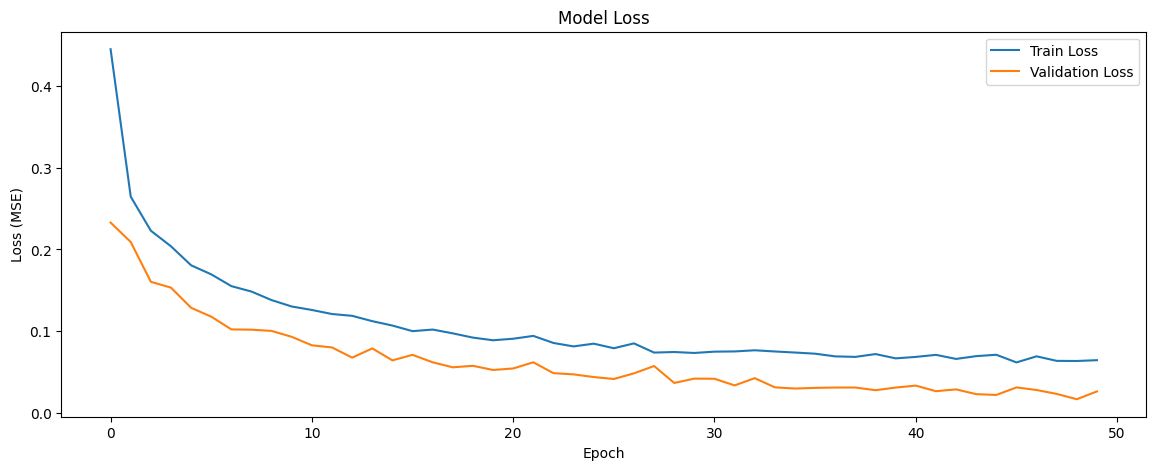

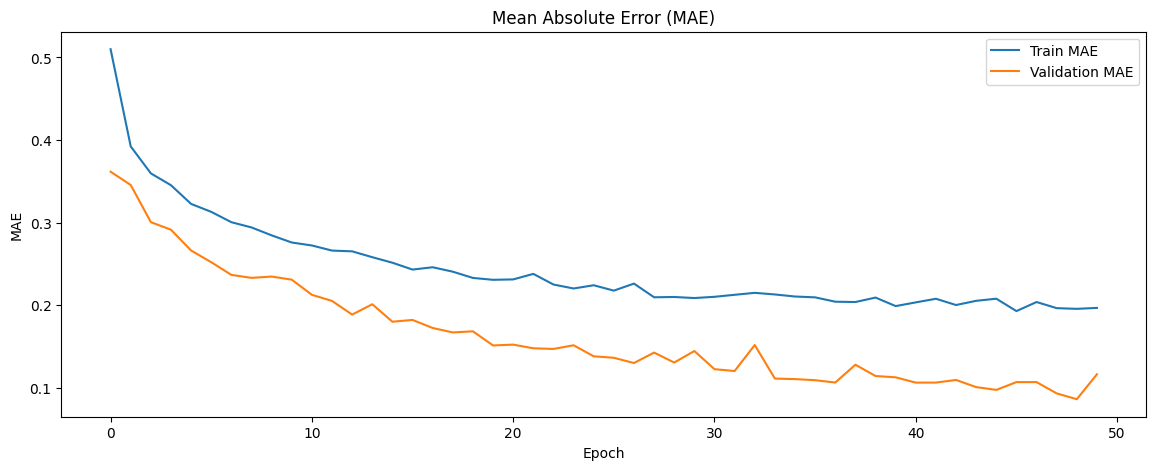

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras_tuner as kt
from datetime import datetime
import os


log_dir = os.path.join("logs", "fit", datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


final_combined_data_cleaned = pd.read_excel('6. final_dataset.xlsx')

final_combined_data_cleaned['Phosphorus'] = np.log1p(final_combined_data_cleaned['Phosphorus'])
final_combined_data_cleaned['Potassium'] = np.log1p(final_combined_data_cleaned['Potassium'])
final_combined_data_cleaned['OM'] = np.log1p(final_combined_data_cleaned['OM'])
final_combined_data_cleaned['EC'] = np.log1p(final_combined_data_cleaned['EC'])
final_combined_data_cleaned['temperature_2m_max'] = np.cbrt(final_combined_data_cleaned['temperature_2m_max'])
final_combined_data_cleaned['temperature_2m_min'] = np.cbrt(final_combined_data_cleaned['temperature_2m_min'])
final_combined_data_cleaned['rain_sum'] = np.cbrt(final_combined_data_cleaned['rain_sum'])
final_combined_data_cleaned['sunshine_duration'] = np.cbrt(final_combined_data_cleaned['sunshine_duration'])
final_combined_data_cleaned['wind_speed_10m_max'] = np.cbrt(final_combined_data_cleaned['wind_speed_10m_max'])
final_combined_data_cleaned['et0_fao_evapotranspiration_sum'] = np.cbrt(final_combined_data_cleaned['et0_fao_evapotranspiration_sum'])

label_encoder = LabelEncoder()
final_combined_data_cleaned['Season'] = label_encoder.fit_transform(final_combined_data_cleaned['season'])

final_combined_data_encoded = pd.get_dummies(final_combined_data_cleaned, columns=['Condition'])

features = ['year', 'pH', 'EC', 'Phosphorus', 'Potassium', 'OM',  'Urea1', 'Urea2', 'Urea3', 'Urea4', 
            'TSP0', 'MOP1', 'MOP2', 'MOP3', 'temperature_2m_max', 'temperature_2m_min', 'sunshine_duration', 
            'rain_sum', 'wind_speed_10m_max', 'et0_fao_evapotranspiration_sum', 'Season']

features.extend([col for col in final_combined_data_encoded.columns if col.startswith('Condition_')]) 

X = final_combined_data_encoded[features]
y = final_combined_data_encoded['Yield']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)


def build_model(hp):
    model = Sequential()
    
    model.add(Dense(units=hp.Int('units_0', min_value=16, max_value=48, step=16),
                    activation=hp.Choice('activation', values=['relu', 'tanh']),
                    input_dim=X_train.shape[1]))
    
    for i in range(1, hp.Int('num_layers', 1, 2)):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=16, max_value=48, step=16),
                        activation=hp.Choice('activation', values=['relu', 'tanh'])))
        model.add(BatchNormalization())
        model.add(Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    
    model.add(Dense(1))
    
    hp_optimizer = hp.Choice('optimizer', values=['adam', 'sgd'])
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    
    if hp_optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model


tuner = kt.Hyperband(
    build_model,
    objective='val_mean_absolute_error',
    max_epochs=50,
    factor=3,
    directory='keras_tuner_dir',
    project_name='tune_yield_prediction'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) 


tuner.search(X_train, y_train, 
             epochs=50, 
             validation_data=(X_test, y_test), 
             callbacks=[early_stopping, tensorboard_callback])


best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of layers: {best_hps.get('num_layers')}
The optimal number of units in each layer: {[best_hps.get(f'units_{i}') for i in range(best_hps.get('num_layers'))]}
The optimal activation function: {best_hps.get('activation')}
The optimal dropout rate: {best_hps.get('dropout')}
The optimal optimizer: {best_hps.get('optimizer')}
The optimal learning rate: {best_hps.get('learning_rate')}
""")


best_log_dir = os.path.join("logs", "fit", "best_model_" + datetime.now().strftime("%Y%m%d-%H%M%S"))
best_tensorboard_callback = TensorBoard(log_dir=best_log_dir, histogram_freq=1)

best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(X_train, y_train, 
                         validation_data=(X_test, y_test), 
                         epochs=50, 
                         callbacks=[early_stopping, best_tensorboard_callback])


plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(loc='upper right')
plt.show()